In [1]:
!pip install transformers datasets evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [11]:
from datasets import load_dataset
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, TrainingArguments, Trainer
import numpy as np
import evaluate

# Load SQuAD dataset (used only 10% because of low availability of resources)
# we can change it later after buying the gpu units
dataset = load_dataset("squad", split="train[:10%]")

# Preprocessing function
def preprocess_function(examples, tokenizer):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length"
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions, end_positions = [], []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = start_char + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)
        idx = next((idx for idx, seq in enumerate(sequence_ids) if seq == 1), None)
        if idx is None:
            start_positions.append(0)
            end_positions.append(0)
            continue
        context_start = idx
        context_end = next(
            (idx for idx, seq in enumerate(sequence_ids[idx:], start=idx) if seq != 1),
            len(sequence_ids)
        ) - 1
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            try:
                start_idx = next(
                    idx for idx in range(context_start, context_end + 1)
                    if offset[idx][0] <= start_char and offset[idx][1] > start_char
                )
            except StopIteration:
                start_idx = 0
            try:
                end_idx = next(
                    idx for idx in range(context_end, context_start - 1, -1)
                    if offset[idx][1] >= end_char
                )
            except StopIteration:
                end_idx = 0

            start_positions.append(start_idx)
            end_positions.append(end_idx)

    inputs["start_positions"], inputs["end_positions"] = start_positions, end_positions
    return inputs

metric = evaluate.load("squad")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    start_logits, end_logits = predictions
    start_positions, end_positions = labels

    predicted_starts = np.argmax(start_logits, axis=1)
    predicted_ends = np.argmax(end_logits, axis=1)

    return {
        "start_accuracy": np.mean(predicted_starts == start_positions),
        "end_accuracy": np.mean(predicted_ends == end_positions)
    }


In [12]:
# distilbert model
model_name = "distilbert-base-uncased-distilled-squad"
model = AutoModelForQuestionAnswering.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenized_dataset = dataset.map(lambda x: preprocess_function(x, tokenizer), batched=True, remove_columns=dataset.column_names)

training_args = TrainingArguments(
    output_dir="./results_distilbert",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    eval_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()


Map:   0%|          | 0/8760 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-12-2806e59d4b31>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Start Accuracy,End Accuracy
1,0.351500,0.165873,0.896233,0.999315
2,0.212000,0.077334,0.952397,0.999886
3,0.130800,0.053409,0.966667,0.999886


{'eval_loss': 0.05340934172272682,
 'eval_start_accuracy': 0.9666666666666667,
 'eval_end_accuracy': 0.9998858447488584,
 'eval_runtime': 110.8248,
 'eval_samples_per_second': 79.044,
 'eval_steps_per_second': 9.88,
 'epoch': 3.0}

In [13]:
import matplotlib.pyplot as plt


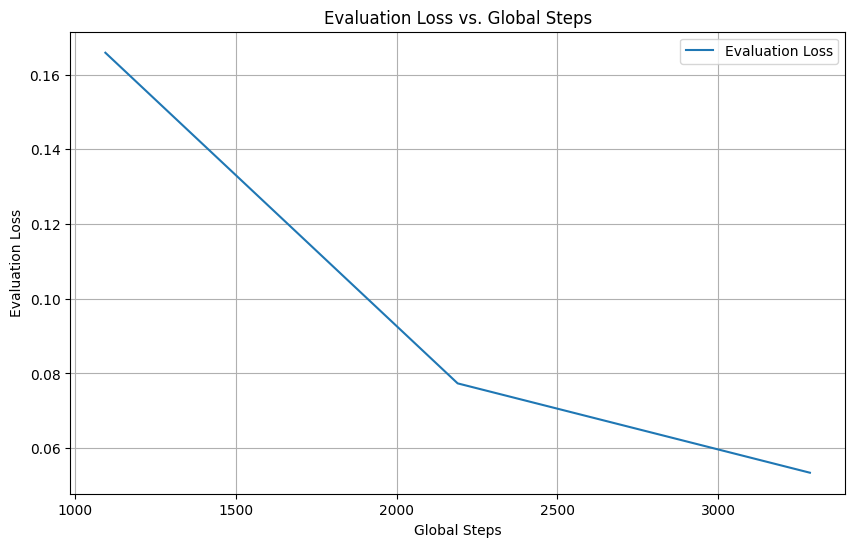

In [15]:


log_history = trainer.state.log_history

# Extract evaluation loss and global steps
eval_losses = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
global_steps = [log['step'] for log in log_history if 'eval_loss' in log]


# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(global_steps, eval_losses, label='Evaluation Loss')
plt.xlabel('Global Steps')
plt.ylabel('Evaluation Loss')
plt.title('Evaluation Loss vs. Global Steps')
plt.legend()
plt.grid(True)
plt.show()

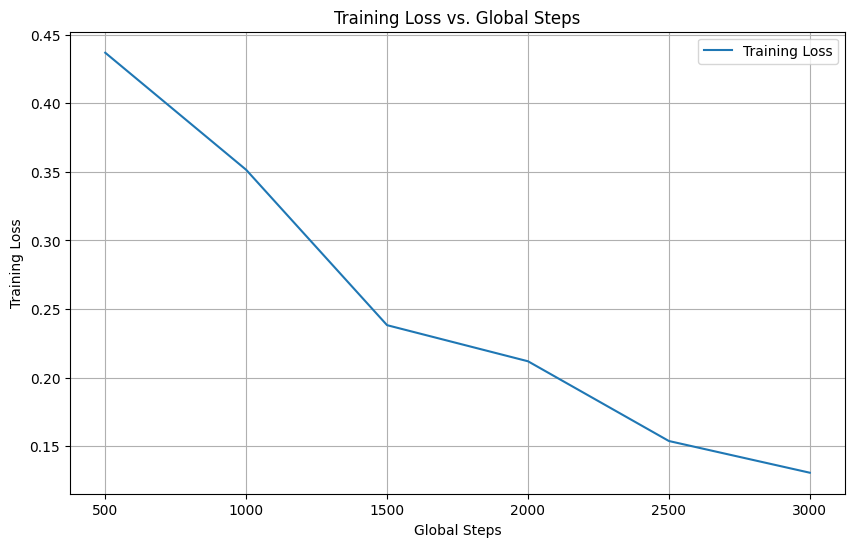

In [19]:


log_history = trainer.state.log_history

# Extract evaluation loss and global steps
train_losses = [log['loss'] for log in log_history if 'loss' in log]
global_steps = [log['step'] for log in log_history if 'loss' in log]


# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(global_steps, train_losses, label='Training Loss')
plt.xlabel('Global Steps')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Global Steps')
plt.legend()
plt.grid(True)
plt.show()